In [146]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [147]:
con = sqlite3.connect("../unified_CD2.db")
cur = con.cursor()
df = pd.read_sql_query("SELECT * FROM prod_desc", con)

df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, 'little'))# converting binary to dec int

In [148]:
descriptors = df.columns[9:]
unidescriptors = [d for d in descriptors if len(df[d].unique()) < 2]# checking which descriptors have singular entries
print('len desc, len unidesc', len(descriptors), len(unidescriptors))
print(df.shape)
df.drop(unidescriptors, axis = 1, inplace = True)# dropping descriptors with singular value for all samples
print(df.shape)

len desc, len unidesc 210 69
(12801, 219)
(12801, 150)


In [149]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time

## initially tried with non scaled descriptors

In [150]:
X = df.iloc[:, 9:]
X.shape
y = df['AB']
print(X.shape, y.shape)

(12801, 141) (12801,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)
print(y_train.value_counts())# check that training with AB = 0&!1

AB
1    4845
0    4115
Name: count, dtype: int64


In [7]:
K = []
training = []
test = []
ts = []
# scores = {}

for k in range(2, 10):
    print('running k= ', k)
    t0 = time.time()
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    ts.append(time.time()-t0)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)
    #scores[k] = [training_score, test_score]

running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9


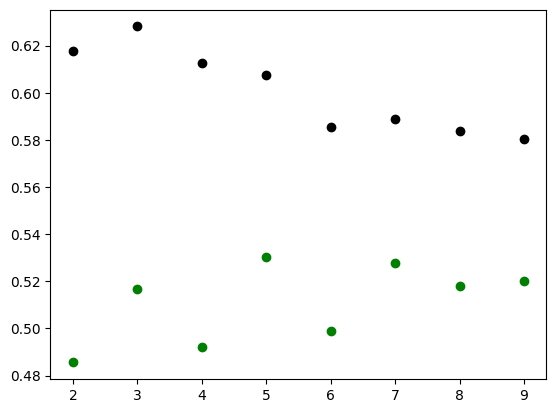

In [8]:
# choosing best K
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()

## trying with normalisation and pca of descriptors



In [151]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [152]:
ndescriptors = [d for d in X.columns if len(X[d].value_counts() ) > 1000]
# assuming this is sufficient requirement to identify non categorical descriptors
print(ndescriptors)

['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA8', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_ESt

In [153]:
dfn = df.copy()# already discarded noninforming descriptors before
dfn[ndescriptors] = normalize(dfn[ndescriptors], norm = 'l2')
df.shape, dfn.shape

((12801, 150), (12801, 150))

In [159]:
dfn.head(2)

,index,id,name,AB,description,OX,source,seq,valid,MaxAbsEStateIndex,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
0,0.0,ADAM_2177,InverPep_ADAM_2177,1,None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,yes,1.484495e-78,...,2,0,0,1,0,0,0,3,0,5
1,NaN,P85444,PPIA_PENGL,0,Peptidyl-prolyl cis-trans isomerase (Fragment),Penicillium glabrum OX=69773,uniprot_swissprot.fasta,KFADENFQLKH,yes,1.101793e-22,...,2,0,0,1,0,0,0,2,0,2


In [166]:
X = dfn.iloc[:, 9:]
X.shape
y = dfn['AB']
print(X.shape, y.shape)

(12801, 141) (12801,)


In [167]:
pca = PCA(n_components = 0.99)# can already retain over 0.8 of variance with one descriptor
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
Xpca = pca.transform(X)

[0.89323951 0.03769263 0.03231509 0.01381121 0.00612537 0.00447824
 0.00375534]
[31720.71335956  6516.09161981  6033.39408825  3944.34418206
  2626.78940482  2246.0146149   2056.75872574]


In [98]:
# taken from: https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
pca.components_.shape# 7, 141
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(n_pcs)]

initial_feature_names = dfn.columns[9:]
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {f'PC{i}': most_important_names[i].values for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df.columns = ['PC', 'Descriptors']
df[['3', '2', '1']] = pd.DataFrame(df.Descriptors.tolist(), index= df.index)
df.drop('Descriptors', axis=1, inplace=True)

df.to_latex('pca highest components latex.txt')

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_41979/2010919286.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('pca highest components latex.txt')


In [99]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size = 0.30, random_state=0)
print(y_train.value_counts())


1    4845
0    4115
Name: AB, dtype: int64


In [ ]:
K = []
training = []
test = []
ts = []
# scores = {}

for k in range(2, 21):
    print('running k= ', k)
    t0 = time.time()
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    ts.append(time.time()-t0)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)

running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20


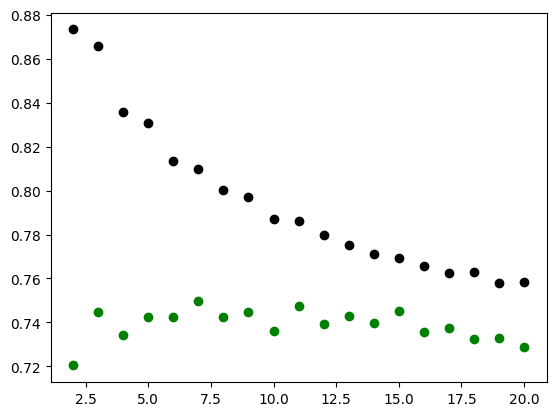

In [ ]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()

# plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


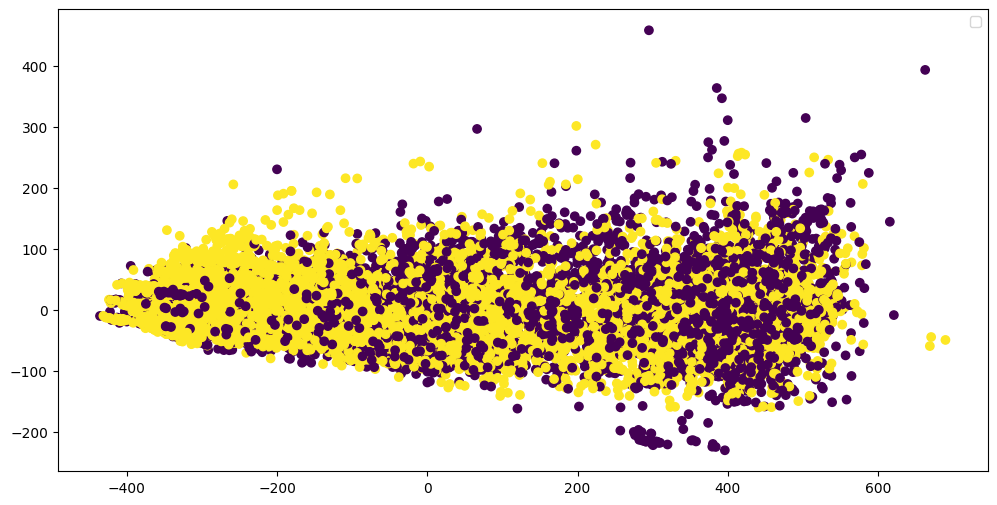

In [16]:
# first two dimensions of pca

fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(Xpca[:, 0], Xpca[:, 1], c = y[:].values)
plt.legend()

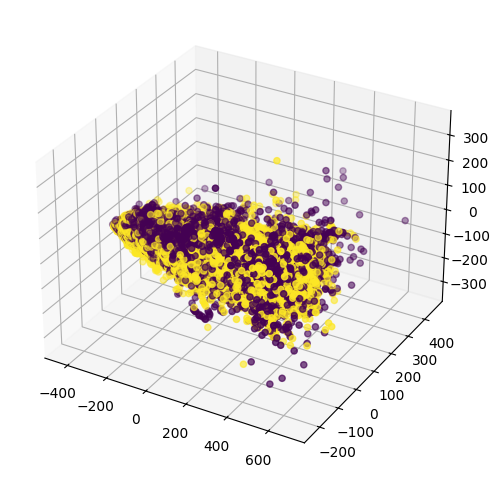

In [17]:
# first three dimensions of pca

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c = y[:].values)

In [18]:
groupex = dfn.groupby(['source'])['source'].apply(lambda x: x.index[0])# example point per group, for labeling purposes
groupex

source
APD_sequence_release_09142020.fasta      92
BAAMPs_data.csv                        8158
DADP.html                               814
HIPdb_data.xls                         1096
InverPep.fasta                            0
LAMP2.fasta                             227
dbaasp_ribosomal.txt                   1086
dramp_antimicrobial.fasta              2100
uniprot_swissprot.fasta                   1
Name: source, dtype: int64

In [19]:
for n, i in zip(groupex.index, groupex.values):
  print(i, n)

92 APD_sequence_release_09142020.fasta
8158 BAAMPs_data.csv
814 DADP.html
1096 HIPdb_data.xls
0 InverPep.fasta
227 LAMP2.fasta
1086 dbaasp_ribosomal.txt
2100 dramp_antimicrobial.fasta
1 uniprot_swissprot.fasta


In [20]:
ls = [i for i in groupex.values]
[i for i in groupex.index]

['APD_sequence_release_09142020.fasta',
 'BAAMPs_data.csv',
 'DADP.html',
 'HIPdb_data.xls',
 'InverPep.fasta',
 'LAMP2.fasta',
 'dbaasp_ribosomal.txt',
 'dramp_antimicrobial.fasta',
 'uniprot_swissprot.fasta']

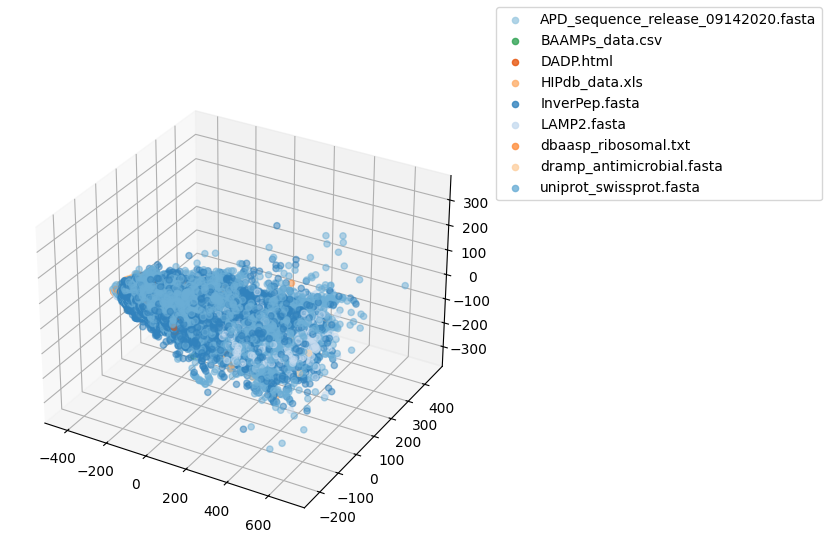

In [21]:


dcols = {n:i for i, n in enumerate( dfn['source'].unique() )}
import matplotlib as mpl
viridis = mpl.colormaps['tab20c']#(range(len(dcols)) )#.resampled(len(dcols))
lcols = [viridis(dcols[s]) for s in dfn['source'].values]


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

for n, i in zip(groupex.index, groupex.values):
  #print(n, i, lcols[i])
  ax.scatter(Xpca[i, 0], Xpca[i, 1], Xpca[i, 2], color = lcols[i], alpha = 0.8, label = n)

ax.scatter(Xpca[:, 0], Xpca[:, 1], Xpca[:, 2], c = lcols, alpha = 0.5)

fig.legend()



# Kfold CV

In [22]:
from sklearn.model_selection import KFold

In [100]:
Xpca.shape

(12801, 7)

In [ ]:
kf = KFold(n_splits=10)

outputs = {}
i = 0
for train, test in kf.split(Xpca):
  print(i)
  training = []
  testing = []
  K = []
  ts = []

  X_train = Xpca[train, :]
  X_test = Xpca[test, :]
  y_train = y[train]
  y_test = y[test]
  print( X_train.shape, X_test.shape, y_train.shape, y_test.shape )

  for k in range(2, 21):
      print('running k= ', k)
      t0 = time.time()
      clf = KNeighborsClassifier(n_neighbors = k)
      clf.fit(X_train, y_train)
      ts.append(time.time()-t0)

      training_score = clf.score(X_train, y_train)
      test_score = clf.score(X_test, y_test)

      K.append(k)
      training.append(training_score)
      testing.append(test_score)
  outputs[i] = (K, training, testing)
  i+=1



0
(11520, 7) (1281, 7) (11520,) (1281,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
1
(11521, 7) (1280, 7) (11521,) (1280,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
2
(11521, 7) (1280, 7) (11521,) (1280,)
running k=  2
running k=  3
running k=  4
running k=  5
running k=  6
running k=  7
running k=  8
running k=  9
running k=  10
running k=  11
running k=  12
running k=  13
running k=  14
running k=  15
running k=  16
running k=  17
running k=  18
running k=  19
running k=  20
3
(11521, 7) (1280, 7) (11521,) (1280,)
running k

In [ ]:
nKs = 19
folds = 10

meantraining = np.zeros((nKs, folds))
meantesting = np.zeros((nKs, folds))
Ks = np.zeros((nKs, folds))

for f in outputs.keys():# for each fold
  K, tr, te = outputs[f]
  meantraining[:, f] = tr
  meantesting [:, f] = te
  Ks [:, f] = K

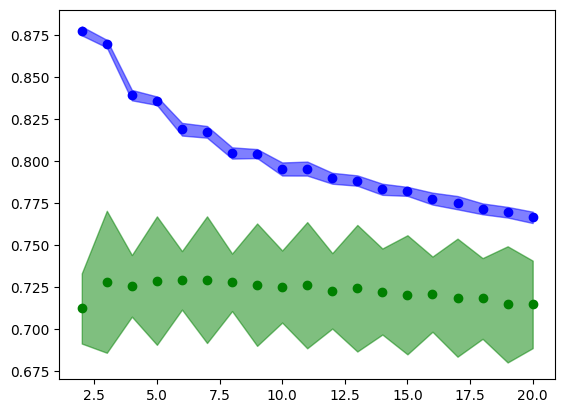

In [ ]:
fig, ax = plt.subplots()

#Ks = np.mean(Ks, axis = 1)

trainsd = np.std(meantraining, axis = 1)
trainmean = np.mean(meantraining, axis = 1)
ax.scatter(Ks, trainmean, color = 'b', label = 'train')
ax.fill_between(Ks, trainmean-trainsd, trainmean+trainsd, alpha = 0.5, color = 'b')

testsd = np.std(meantesting, axis = 1)
testmean = np.mean(meantesting, axis = 1)
ax.scatter(Ks, testmean, color = 'g', label = 'test')
ax.fill_between(Ks, testmean-testsd, testmean+testsd, alpha = 0.5, color = 'g')

fig.legend()



## go with k = 6

In [168]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size = 0.30, random_state=0)

In [169]:
k = 6
t0 = time.time()
clf = KNeighborsClassifier(n_neighbors = k)
clf.fit(X_train, y_train)
t1 = (time.time()-t0)

training_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(t1, training_score, test_score)


0.007301807403564453 0.8133928571428571 0.7425149700598802


auc:  0.8137070341700369


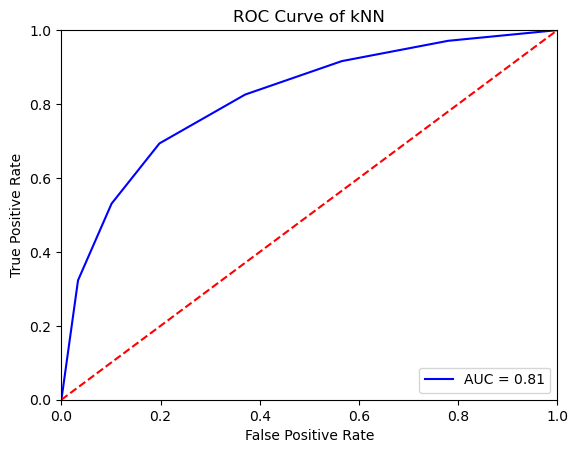

In [170]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
print('auc: ', roc_auc)

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [171]:
y_pred = clf.predict(X_test)
y_pred


array([1, 0, 0, ..., 1, 1, 1])

In [105]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.8106312292358804

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7425149700598802

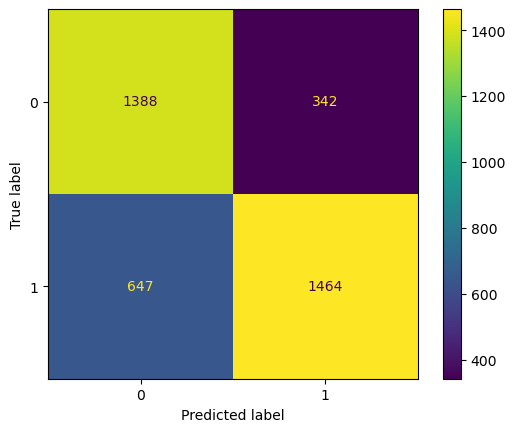

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# checking for correlation in features

In [6]:
X = df.iloc[:, 9:]
X.shape
y = df['AB']
print(X.shape, y.shape)

X_test, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

(12801, 141) (12801,)


In [88]:
corr = X_test.corr()


cmask = abs(corr - np.eye(len(corr ) ) ) > 0.99
cmask &= np.triu(np.ones(corr.shape[0], dtype=bool), k= 1)# because choose triu always sets first inst of corr to false
#cmask = ~cmask
#cmask = np.array(cmask, dtype = int)
cmask

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
MaxAbsEStateIndex,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MaxEStateIndex,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MinAbsEStateIndex,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MinEStateIndex,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
qed,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fr_phenol,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
fr_phenol_noOrthoHbond,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
fr_priamide,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
fr_sulfide,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [89]:
corrlines = {c: corr[cmask[c]].index.values.tolist() for c in X_test.columns if any(cmask[c]) }
# ? cmask[c].index.values.tolist() should also do
#a = [ corrlines[c]:corr[cmask[c]].index.values.tolist()) for c in list(reversed(X_test.columns))[:1] if any(cmask[c]) ]


In [90]:
redunantcols = [s for m in corrlines.values() for s in m] 
redunantcols = set(redunantcols)
redunantcols = list(redunantcols)
len(redunantcols)
# ! 93 for thr 0.9, 89 for thr 0.95, 74 for thr 0.99

74

# comparison of false positive vs true positive

In [254]:
# cm is literally 2 2 array
# fpr, tpr, are arrays
# trying to get indices of train test split without specifiying beforehand

lrange = np.arange(y.size)
X_train_ids, X_test_ids, y_train_ids, y_test_ids = train_test_split(lrange, lrange, test_size = 0.30, random_state=0)
print(sum(X_train_ids-y_train_ids))

0


In [339]:
test = dfn.copy()
test = test.iloc[X_test_ids, :]
test.drop('index', axis = 1, inplace=True)
#test.set_index('id', inplace=True)
test.head(2)

,id,name,AB,description,OX,source,seq,valid,MaxAbsEStateIndex,MaxEStateIndex,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
7847,ADAM_3120,InverPep_ADAM_3120,1,None,alien,InverPep.fasta,IIGHLIKTALGMLGL,yes,1.289875e-26,1.289875e-26,...,0,0,0,1,0,0,0,0,1,1
4699,P22688,TKNA_AQUCT,0,Ranatachykinin-A,Aquarana catesbeiana OX=8400,uniprot_swissprot.fasta,KPSPDRFYGLM,yes,1.417719e-20,1.417719e-20,...,2,0,1,0,0,1,1,0,1,2


In [340]:
testX = test.iloc[:, 8:]
testXpca = pca.transform(testX)
print( testXpca.shape )

(3841, 7)


In [341]:
y_pred = clf.predict(X_test)
dpred = np.array(y_test - y_pred) # this was isseu, not indexed after subtraction

In [342]:
labels = {0:'tn', 1:'tp', -1:'fp', 2:'fn'}

tlabels = [labels[ (2*dpred[i] + y_pred[i]) ] for i,_ in enumerate(y_pred)]

test.insert(0, 'label', tlabels)
test.head(1)

,label,id,name,AB,description,OX,source,seq,valid,MaxAbsEStateIndex,...,fr_benzene,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane
7847,tp,ADAM_3120,InverPep_ADAM_3120,1,None,alien,InverPep.fasta,IIGHLIKTALGMLGL,yes,1.289875e-26,...,0,0,0,1,0,0,0,0,1,1


In [237]:
invlabels = {v:k for k,v in zip(labels.keys(), labels.values())}

cols = [invlabels[i] for i in test['label']]

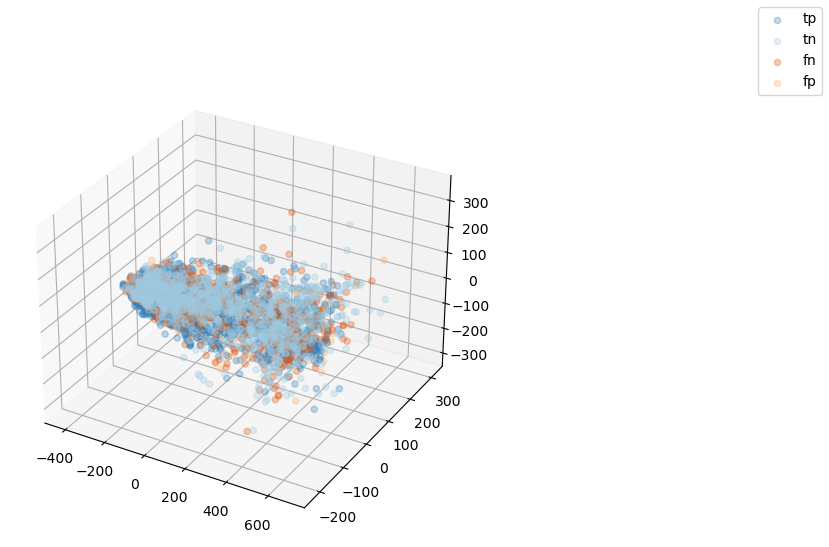

In [305]:
cmap = plt.colormaps['tab20c']#["viridis"]
mycolors = cmap(np.arange(4)*2)


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']

for i, l in enumerate(['tp', 'tn', 'fn', 'fp']):
    ids = np.where(test['label'] == l)[0] #.index.to_list() wont work as indexing from original all data
    ax.scatter(testXpca[ids, 0], testXpca[ids, 1], testXpca[ids, 2], color=mycolors[i], label=l, alpha = 0.3)

fig.legend()

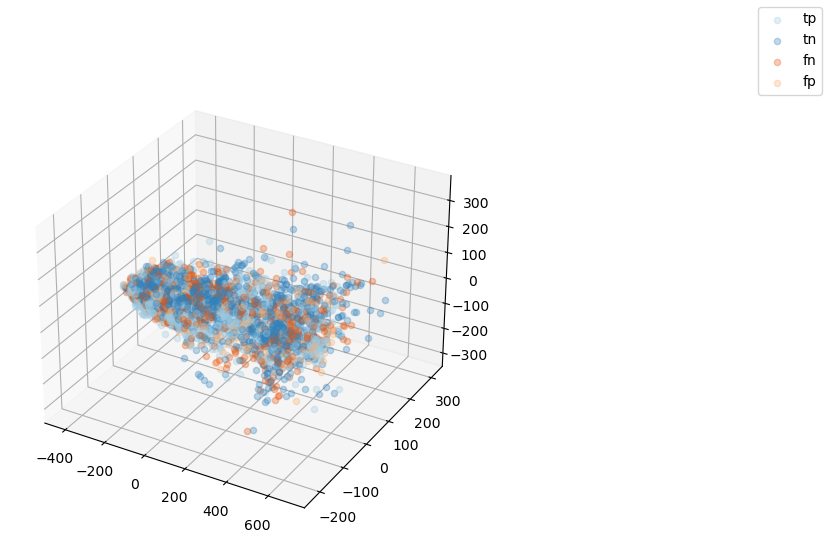

In [313]:
# redoing with scattering along line, so dont have one color ontop

cmap = plt.colormaps['tab20c']#["viridis"]
mycolors = cmap(np.arange(4)*2)


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']

for ids in range(test.shape[0]):
    type = test['label'].values[ids]
    col = invlabels[type]
    col = mycolors[col]
    if ids in labelids:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], testXpca[ids, 2], color=col, alpha = 0.3, label= type)
    else:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], testXpca[ids, 2], color=col, alpha = 0.3)


fig.legend()

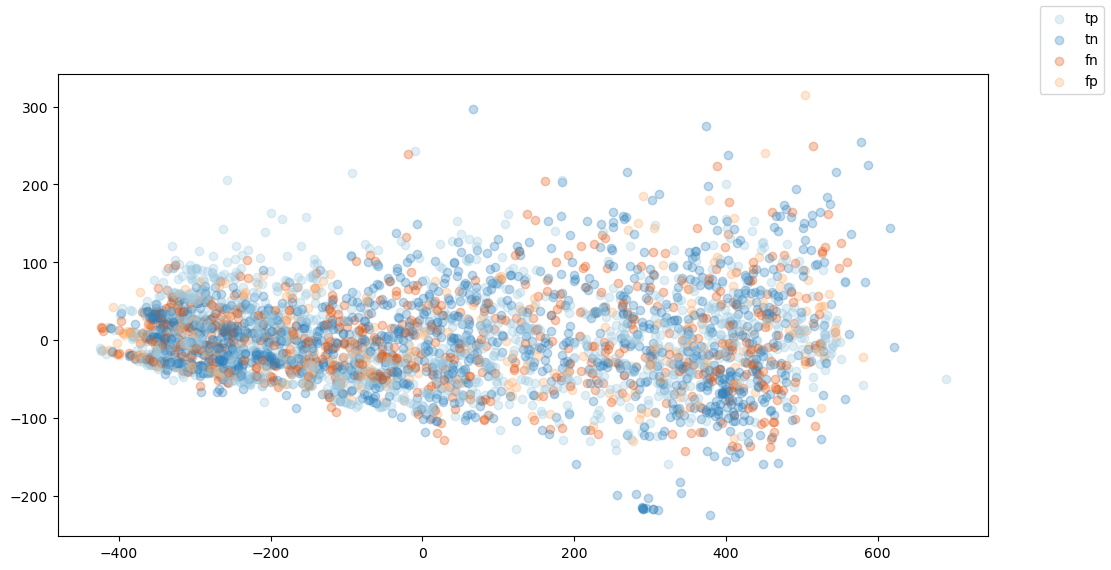

In [316]:
# redoing with scattering along line, so dont have one color ontop
#in 2d

cmap = plt.colormaps['tab20c']#["viridis"]
mycolors = cmap(np.arange(4)*2)


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']

for ids in range(test.shape[0]):
    type = test['label'].values[ids]
    col = invlabels[type]
    col = mycolors[col]
    if ids in labelids:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], color=col, alpha = 0.3, label= type)
    else:
        ax.scatter(testXpca[ids, 0], testXpca[ids, 1], color=col, alpha = 0.3)


fig.legend()

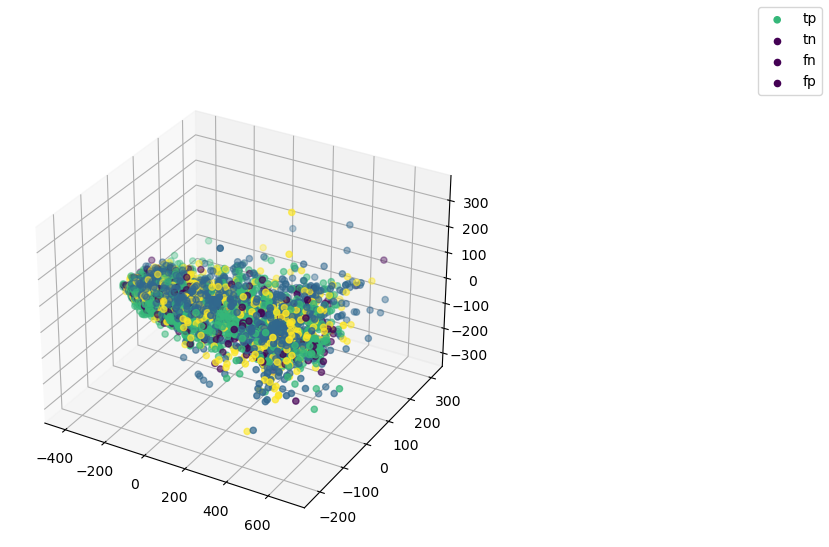

In [301]:

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(testXpca[:, 0], testXpca[:, 1], testXpca[:, 2], c=cols)

labelids = [0, 1, 5, 15] # 0=1, 1=0, 5 = 2, 15 = -1 sample point of each group for labeling
labellabels = ['tp', 'tn', 'fn', 'fp']
for j, i in enumerate(labelids):
    ax.scatter(testXpca[i, 0], testXpca[i, 1], testXpca[i, 2], c=cols[i], label = labellabels[j])

fig.legend(labellabels)

,id,name,AB,description,OX,source,seq,valid,MaxAbsEStateIndex,MaxEStateIndex,...,fr_bicyclic,fr_guanido,fr_imidazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_priamide,fr_sulfide,fr_unbrch_alkane,label
7847,ADAM_3120,InverPep_ADAM_3120,1,None,alien,InverPep.fasta,IIGHLIKTALGMLGL,yes,1.289875e-26,1.289875e-26,...,0,0,1,0,0,0,0,1,1,tp
11087,ADAM_6648,InverPep_ADAM_6648,1,None,alien,InverPep.fasta,KLCERPSGTWSGVCGNNNACRNQCINLEKARHGSCNYVFPAHKCIC...,yes,2.621347e-151,2.621347e-151,...,1,3,2,1,2,2,7,0,6,tp
7154,ADAM_3920,InverPep_ADAM_3920,1,None,alien,InverPep.fasta,LQDAAVGWGRRCPQCPRCPSCPSCPRCPRCPRCKCNPK,yes,1.698253e-106,1.698253e-106,...,1,6,0,1,0,0,3,0,8,tp
8566,DBAASP1441,V681[V13A],1,None,alien,InverPep.fasta,KWKSFLKTFKSAAKTVLHTALKAISS,yes,1.752907e-70,1.752907e-70,...,1,0,1,1,0,0,0,0,6,tp
4544,2948,P19,1,"(UCLL1, rumen microbiome, bacteria)\r\n",alien,APD_sequence_release_09142020.fasta,RLLLVMIGLRSKIKWHSGI,yes,5.160878e-49,5.160878e-49,...,1,2,1,1,0,0,0,1,4,tp


In [357]:
# checking difference pca component

tp = test[test.label == 'tp']
fp = test[test.label == 'fp']
tn = test[test.label == 'tn']
fn = test[test.label == 'fn']

p = pd.concat((tp, fp))
n = pd.concat((tn, fn))


In [359]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# predicted positively but true/false
rf = RandomForestClassifier(random_state =0)

rf.fit(p.iloc[:, 9:], p['AB'])# had to add label to col=0, else 


RandomForestClassifier(random_state=0)

In [347]:
y_pred = rf.predict(p.iloc[:, 9:])
accuracy_score(p['AB'], y_pred)

1.0

In [349]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [353]:
pd.Series(rf.feature_importances_, index=p.columns[9:]).sort_values(ascending=False)

fr_unbrch_alkane     0.036175
HeavyAtomCount       0.031013
NumRotatableBonds    0.028931
PEOE_VSA10           0.027908
SMR_VSA4             0.027680
                       ...   
AvgIpc               0.000000
qed                  0.000000
PEOE_VSA8            0.000000
VSA_EState5          0.000000
VSA_EState8          0.000000
Length: 141, dtype: float64

In [361]:
# for falsesly predicting negative

rf = RandomForestClassifier()
rf.fit(n.iloc[:, 9:], n['AB'])

y_pred = rf.predict(n.iloc[:, 9:])
accuracy_score(n['AB'], y_pred)

1.0

In [362]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [363]:
pd.Series(rf.feature_importances_, index=n.columns[9:]).sort_values(ascending=False)

SlogP_VSA4           0.031944
SMR_VSA4             0.031695
HeavyAtomCount       0.029588
EState_VSA9          0.029015
NumRotatableBonds    0.027633
                       ...   
Chi0v                0.000000
Chi1                 0.000000
Chi1v                0.000000
Chi2n                0.000000
HallKierAlpha        0.000000
Length: 141, dtype: float64

In [73]:
"""
# obsolete

coldict = {k: v for k, v in zip(X_test.columns, X_test.columns)}#coldict.keys, coldict.values)}

def corrcols(x):
    ids = cmask[cmask[x]].index.values# ids with which col correlates
    for i in ids:
        print(coldict[i])
        try: # try to add to values of correlated col, if already del, just add to others
            coldict[i] = (coldict[i], coldict[x])#+=(coldict[x].values)
        except:
            pass
    #coldict.pop(x)
    coldict[x] = 


s = [corrcols(c) for c in X_test.columns if any(cmask[c]) ]

m = ~(corr.where( abs(corr - np.eye(len(corr ) ) > 0.7), dtype=bool)) # where = mask
m

m = (corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.7).any()
m

"""

'\n# obsolete\n\ncoldict = {k: v for k, v in zip(X_test.columns, X_test.columns)}#coldict.keys, coldict.values)}\n\ndef corrcols(x):\n    ids = cmask[cmask[x]].index.values# ids with which col correlates\n    for i in ids:\n        print(coldict[i])\n        try: # try to add to values of correlated col, if already del, just add to others\n            coldict[i] = (coldict[i], coldict[x])#+=(coldict[x].values)\n        except:\n            pass\n    #coldict.pop(x)\n    coldict[x] = \n\n\ns = [corrcols(c) for c in X_test.columns if any(cmask[c]) ]\n'